本章开始构建一个字符识别模型，基于对赛题理解本章将构建一个定长多字符分类模型。

## 3 字符识别模型
---
本章将会讲解卷积神经网络（Convolutional Neural Network, CNN）的常见层，并从头搭建一个字符识别模型。

### 3.1 学习目标
- 学习CNN基础和原理

- 使用Pytorch框架构建CNN模型，并完成训练

### 3.2 CNN介绍

卷积神经网络（简称CNN）是一类特殊的人工神经网络，是深度学习中重要的一个分支。CNN在很多领域都表现优异，精度和速度比传统计算学习算法高很多。**特别是在计算机视觉领域，CNN是解决图像分类、图像检索、物体检测和语义分割的主流模型**。

CNN每一层由众多的卷积核组成，每个卷积核对输入的像素进行卷积操作，得到下一次的输入。随着网络层的增加卷积核会逐渐扩大感受野，并缩减图像的尺寸。



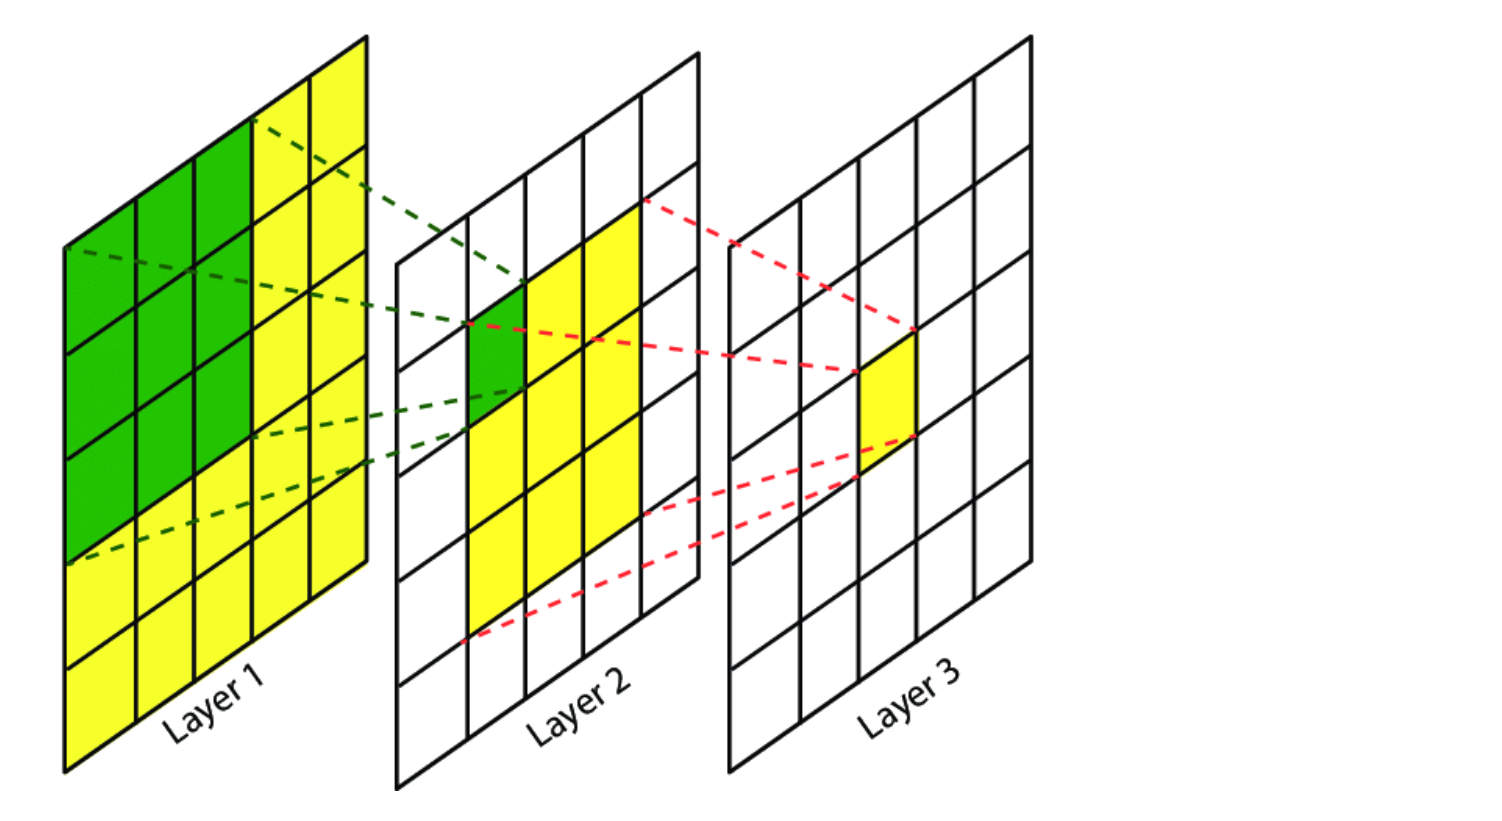

CNN是一种层次模型，输入的是原始的像素数据。CNN通过卷积（convolution）、池化（pooling）、非线性激活函数（non-linear activation function）和全连接层（fully connected layer）构成。

如下图所示为LeNet网络结构，是非常经典的字符识别模型。两个卷积层，两个池化层，两个全连接层组成。卷积核都是5×5，stride=1，池化层使用最大池化。

- Sub-sampling Layer的解释：
The subsampling layer performs the down sampled operation
on the input maps. This is commonly known as the pooling
layer.

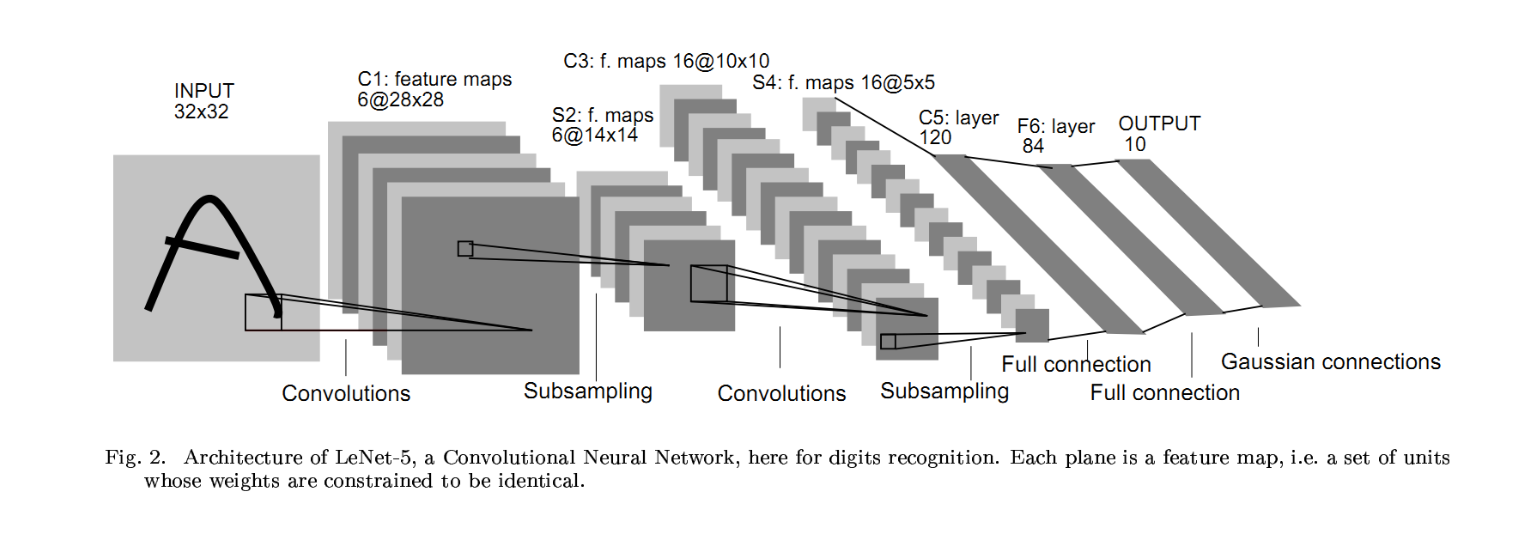

通过多次卷积和池化，CNN的最后一层将输入的图像像素映射为具体的输出。如在分类任务中会转换为不同类别的概率输出，然后计算真实标签与CNN模型的预测结果的差异，并通过反向传播更新每层的参数，并在更新完成后再次前向传播，如此反复直到训练完成 。


与传统机器学习模型相比，CNN具有一种端到端（End to End）的思路。在CNN训练的过程中是直接从图像像素到最终的输出，并不涉及到具体的特征提取和构建模型的过程，也不需要人工的参与。

### 3.3 CNN发展

随着网络结构的发展，研究人员最初发现网络模型结构越深、网络参数越多模型的精度更优。比较典型的是AlexNet、VGG、InceptionV3和ResNet的发展脉络。

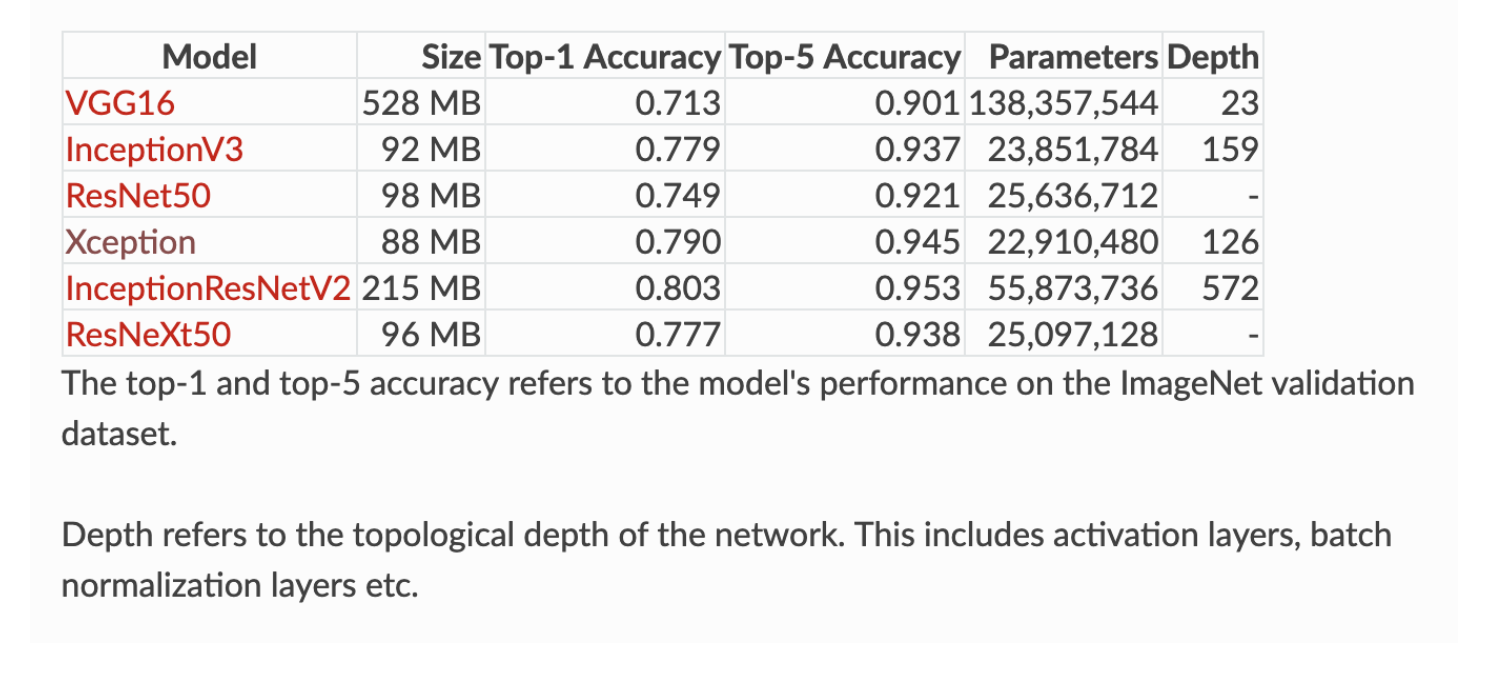

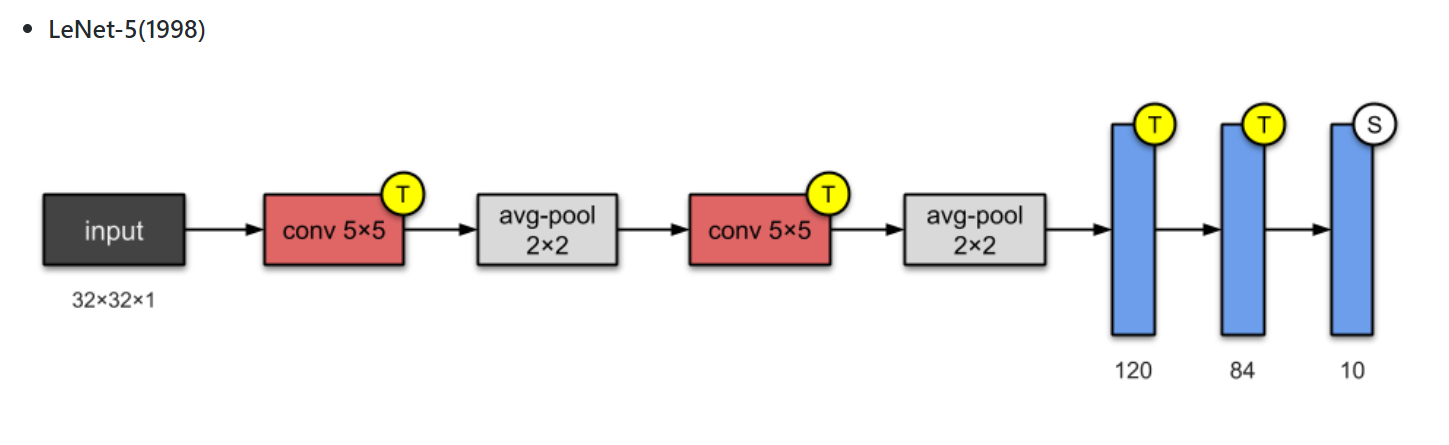

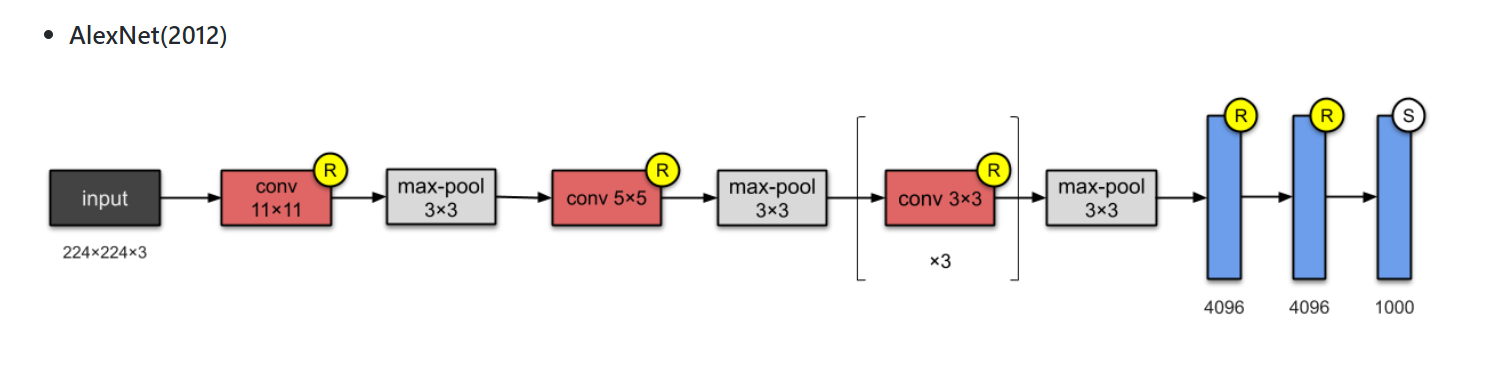

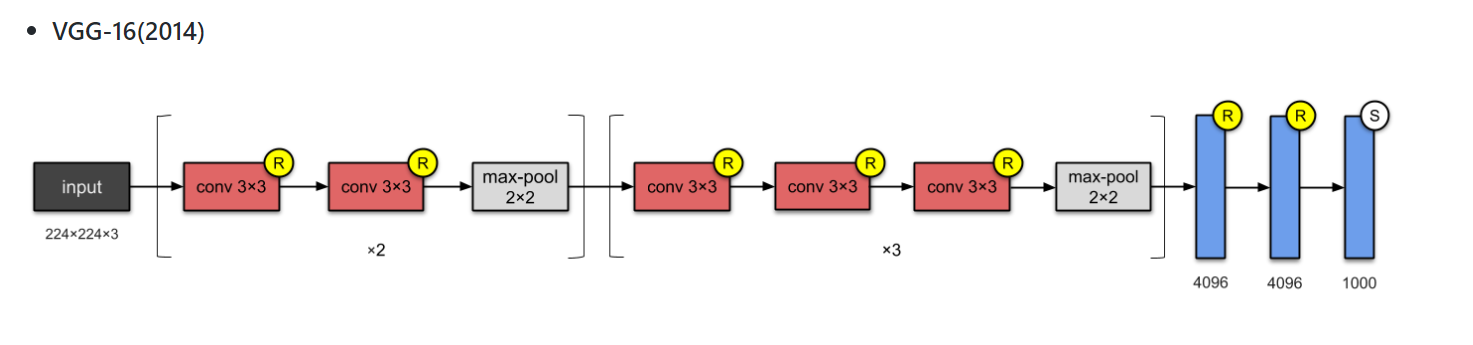

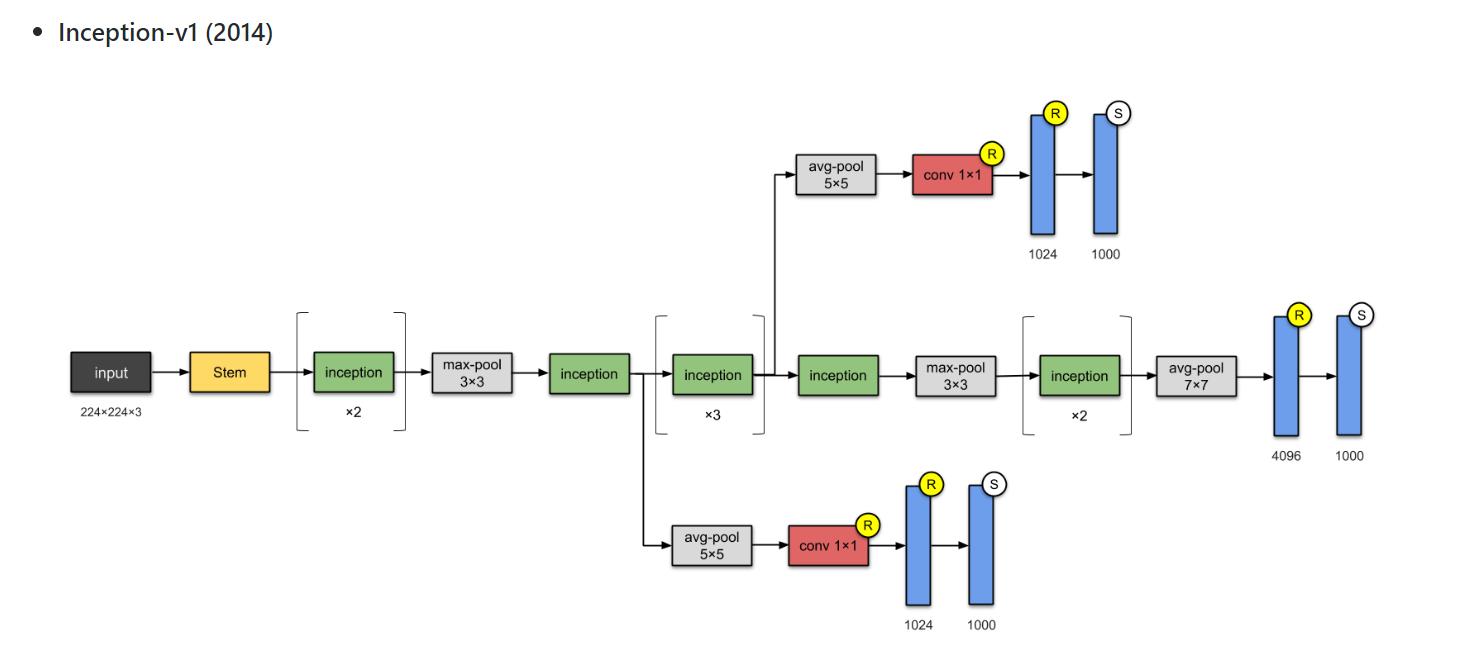

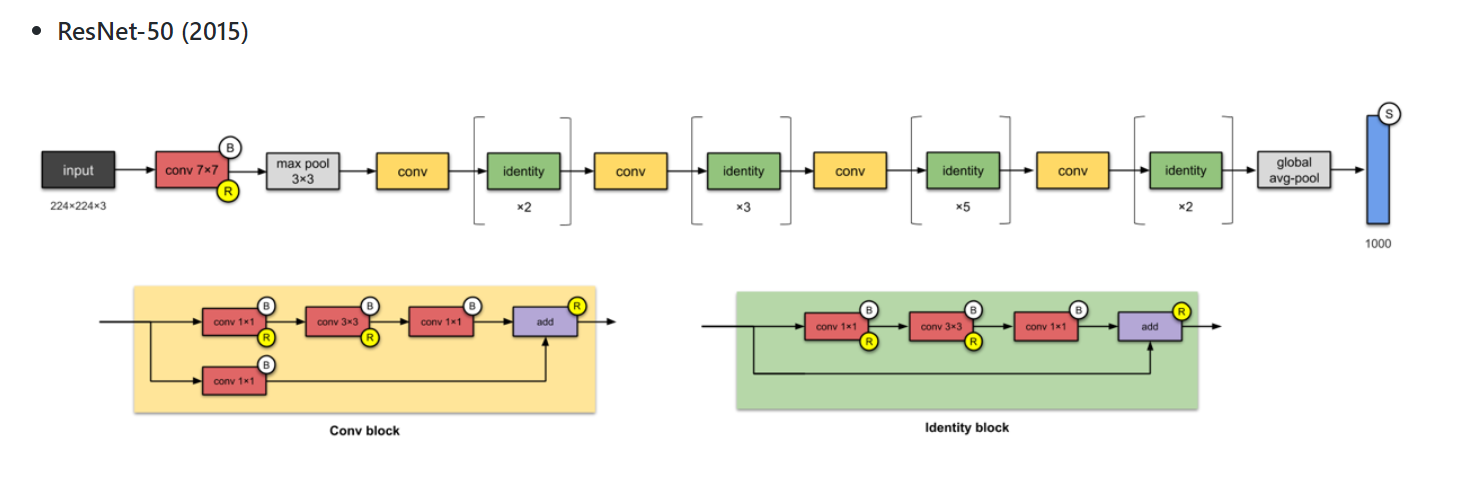

### 3.4 Pytorch构建CNN模型

在上一章节我们讲解了如何使用Pytorch来读取赛题数据集，本节我们使用本章学习到的知识构件一个简单的CNN模型，完成字符识别功能。
在Pytorch中构建CNN模型非常简单，只需要定义好模型的参数和正向传播即可，Pytorch会根据正向传播自动计算反向传播。

在本章我们会构建一个非常简单的CNN，然后进行训练。这个CNN模型包括两个卷积层，最后并联6个全连接层进行分类。

In [1]:
'''task2 构建数据集'''
import os, sys, glob, shutil, json
import cv2

from PIL import Image
import numpy as np

import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)
        
        # 原始SVHN中类别10为数字0
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl)  + (5 - len(lbl)) * [10]
        
        return img, torch.from_numpy(np.array(lbl[:5]))

    def __len__(self):
        return len(self.img_path)

    
train_path = glob.glob('./input/train/*.png')
train_path.sort()
train_json = json.load(open('./input/train.json'))
train_label = [train_json[x]['label'] for x in train_json]
    


# 构建DataLoader对象
train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=4, # 每批样本个数
    shuffle=False, # 是否打乱顺序
    #num_workers=4, # 读取的线程个数
)


In [2]:
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset

# 定义模型
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
        # CNN提取特征模块
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),  
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(), 
            nn.MaxPool2d(2),
        )
        # 
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11)
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
        self.fc5 = nn.Linear(32*3*7, 11)
        self.fc6 = nn.Linear(32*3*7, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        c6 = self.fc6(feat)
        return c1, c2, c3, c4, c5, c6
    
model = SVHN_Model1()

接下来是训练代码：

In [ ]:
for data in train_loader:
    

In [3]:
# 损失函数
criterion = nn.CrossEntropyLoss()
# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.005)

loss_plot, c0_plot = [], []
# 迭代10个Epoch
for epoch in range(1):
    for data in train_loader:
        c0, c1, c2, c3, c4, c5 = model(data[0])
        loss = criterion(c0, data[1][:, 0]) + \
                criterion(c1, data[1][:, 1]) + \
                criterion(c2, data[1][:, 2]) + \
                criterion(c3, data[1][:, 3]) + \
                criterion(c4, data[1][:, 4]) + \
                criterion(c5, data[1][:, 5])
        loss /= 6
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_plot.append(loss.item())
        c0_plot.append((c0.argmax(1) == data[1][:, 0]).sum().item()*1.0 / c0.shape[0])
        
    print(epoch)

RuntimeError: expected scalar type Long but found Int

在训练完成后我们可以将训练过程中的损失和准确率进行绘制，如下图所示。从图中可以看出模型的损失在迭代过程中逐渐减小，字符预测的准确率逐渐升高。

当然为了追求精度，也可以使用在ImageNet数据集上的预训练模型，具体方法如下：

In [ ]:
class SVHN_Model2(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
                
        model_conv = models.resnet18(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])
        self.cnn = model_conv
        
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        self.fc5 = nn.Linear(512, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        # print(feat.shape)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
        c5 = self.fc5(feat)
        return c1, c2, c3, c4, c5

### 3.5 本章小节

在本章中我们介绍了CNN以及CNN的发展，并使用Pytorch构建构建了一个简易的CNN模型来完成字符分类任务。